# k-means clustering of Z1000 HGT over New Zealand

In [1]:
%matplotlib inline
import os
import sys
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.basemap import Basemap as bm
import xarray as xr

In [2]:
from datetime import datetime, timedelta
from dateutil.parser import parse as dparse
import arrow
import calendar

In [3]:
from glob import glob

In [98]:
from IPython.display import Image

### downloading the daily NCEP / NCAR HGT from the ESRL and extract a spatial domain

as the NCEP / NCAR data is available via FTP rather than HTTP, we will use [cURL](https://curl.haxx.se/)  

You can download a **cURL** binary for your platform from [https://curl.haxx.se/dlwiz/](https://curl.haxx.se/dlwiz/)

#### base URL

In [193]:
base_url = 'ftp://ftp.cdc.noaa.gov/Datasets/ncep.reanalysis.dailyavgs/pressure/'

#### Geographical domain and level to extract 

Be aware that the latitude variable is varying from North to South

In [198]:
lonmin = 160
latmin = -55
lonmax = 185
latmax = -25
level = 1000

#### directory where to save the dataset

In [195]:
opath = '../data/NZ/'

In [196]:
from subprocess import call

In [197]:
for y in range(2015, 2016 + 1): 
    filename = "hgt.{}.nc".format(y)
    cmd = "curl --silent {}/{} -o {}/{}".format(base_url, filename, opath, filename)
    r = call(cmd, shell=True)
    if r != 0: 
        print("something went wrong with the download of hgt.{}.nc".format(y))
        pass
    else: 
        dset = xr.open_dataset('{}/{}'.format(opath, filename))
        dset = dset.sel(lat=slice(latmax, latmin), lon=slice(lonmin,lonmax), level=level)
        os.remove('{}/{}'.format(opath, filename))
        dset.to_netcdf('{}/{}'.format(opath, filename))
        dset.close()

### get the list of files in a Python list 

In [4]:
lfiles = glob('../data/NZ/*.nc') 

In [200]:
len(lfiles)

36

### set a random seed to ensure reproducibility of the results 

In [201]:
np.random.seed(42)

## reads in the dataset

In [202]:
dset = xr.open_mfdataset(lfiles)

In [203]:
dset = dset.squeeze(drop=True)

In [204]:
dset.load()

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11, time: 13149)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 -35.0 -37.5 -40.0 -42.5 ...
  * lon      (lon) float32 160.0 162.5 165.0 167.5 170.0 172.5 175.0 177.5 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
Data variables:
    hgt      (time, lat, lon) float64 102.0 100.0 97.0 95.0 94.0 92.0 87.0 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC Reanalysis (1979)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    history:        Thu Nov 30 10:07:05 2017: ncks -FOa -d lat,-55.,-25. -d l...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1
    NCO:            4.4.8

In [205]:
dsetm = dset.mean('time')

### mapping with [cartopy](http://scitools.org.uk/cartopy/)

In [206]:
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

In [207]:
lat = dset.lat
lon = dset.lon

In [208]:
lons, lats = np.meshgrid(lon, lat)

In [209]:
central_longitude = 180.

In [210]:
proj = ccrs.PlateCarree(central_longitude=central_longitude)

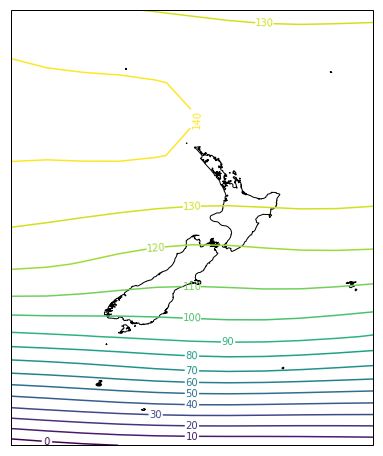

In [211]:
f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})

ax.coastlines('10m')

c = ax.contour(lons - central_longitude, lats, dsetm['hgt'], np.arange(-100, 200, 10))

plt.clabel(c, fmt='%i')

ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

### make a function 

In [212]:
def make_map(X, lons, lats, vmin=-250, vmax=250, step=10, ax=None, central_longitude=180.): 
    if not(ax): 
        central_longitude = 180.
        proj = ccrs.PlateCarree(central_longitude=central_longitude)
        f, ax = plt.subplots(figsize=(10,8), subplot_kw={'projection':proj})
        
    proj = ccrs.PlateCarree(central_longitude=central_longitude)
    
    ax.coastlines('10m')
    
    p = ax.contour(lons - central_longitude, lats, X, np.arange(vmin, vmax + step, step), cmap=plt.cm.RdBu_r)
    
    plt.clabel(p, fmt='%i')

    ax.set_extent([lon.data.min() - central_longitude, lon.data.max() - central_longitude, lat.data.min(), lat.data.max()], crs=proj)

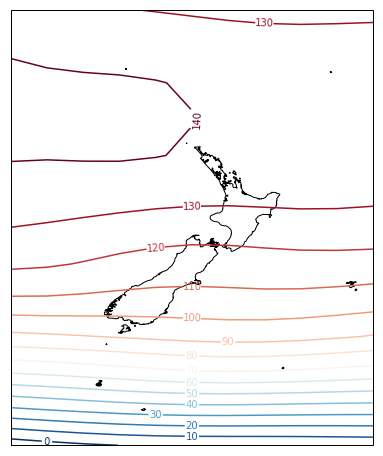

In [213]:
make_map(dsetm['hgt'], lons, lats)

In [16]:
dset

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11, time: 13149)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 -35.0 -37.5 -40.0 -42.5 ...
  * lon      (lon) float32 160.0 162.5 165.0 167.5 170.0 172.5 175.0 177.5 ...
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
Data variables:
    hgt      (time, lat, lon) float64 102.0 100.0 97.0 95.0 94.0 92.0 87.0 ...
Attributes:
    Conventions:    COARDS
    title:          mean daily NMC Reanalysis (1979)
    description:    Data is from NMC initialized reanalysis\n(4x/day).  It co...
    platform:       Model
    history:        Thu Nov 30 10:07:05 2017: ncks -FOa -d lat,-55.,-25. -d l...
    References:     http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reana...
    dataset_title:  NCEP-NCAR Reanalysis 1
    NCO:            4.4.8

In [17]:
hgt = dset['hgt']

In [18]:
hgt_stacked = hgt.stack(latlon=('lat', 'lon'))

In [19]:
hgt_stacked

<xarray.DataArray 'hgt' (time: 13149, latlon: 143)>
array([[ 102.  ,  100.  ,   97.  , ...,  -62.  ,  -50.  ,  -41.  ],
       [ 111.  ,  107.  ,  105.  , ...,  -96.  ,  -83.  ,  -72.  ],
       [ 115.  ,  111.  ,  106.  , ..., -101.  , -107.  , -110.  ],
       ..., 
       [  92.75,   98.5 ,  105.75, ...,  136.75,  128.75,  117.25],
       [  90.5 ,   94.75,   97.5 , ...,  103.25,  116.25,  119.75],
       [ 108.5 ,  109.25,  109.  , ...,  -41.25,   -7.25,   27.25]])
Coordinates:
  * time     (time) datetime64[ns] 1979-01-01 1979-01-02 1979-01-03 ...
  * latlon   (latlon) MultiIndex
  - lat      (latlon) float64 -25.0 -25.0 -25.0 -25.0 -25.0 -25.0 -25.0 ...
  - lon      (latlon) float64 160.0 162.5 165.0 167.5 170.0 172.5 175.0 ...
Attributes:
    units:        m
    precision:    0
    GRIB_id:      7
    GRIB_name:    HGT
    var_desc:     Geopotential height
    dataset:      NCEP Reanalysis Daily Averages
    level_desc:   Multiple levels
    statistic:    Mean
    parent_stat:  

In [20]:
hgt.shape

(13149, 13, 11)

In [21]:
hgt_stacked.shape

(13149, 143)

In [22]:
X = hgt_stacked.data

In [23]:
X.shape

(13149, 143)

In [24]:
type(X)

numpy.ndarray

### do PCA 

In [25]:
from sklearn.decomposition import pca
from sklearn import preprocessing

In [26]:
scaler  = preprocessing.StandardScaler()

In [27]:
scaler = scaler.fit(X)

In [28]:
X = scaler.transform(X)

In [29]:
X.shape

(13149, 143)

In [30]:
X.mean(0)

array([  5.41390983e-17,  -9.88975761e-17,  -6.52675031e-17,
         3.10286607e-16,   1.05711402e-16,  -1.09937325e-16,
        -6.85942038e-17,  -2.33037915e-17,  -1.90694251e-16,
        -9.04879470e-17,   3.46179512e-19,  -1.79844478e-17,
         2.80363188e-17,   2.71839573e-16,   1.77045490e-16,
         1.10844991e-16,  -3.04967263e-16,  -2.97959239e-16,
         1.65148736e-16,  -1.83779104e-16,   1.68602087e-16,
        -2.25126447e-16,  -2.26082662e-16,   1.36424280e-16,
        -7.43737129e-17,   1.79371648e-16,   1.46822330e-16,
         7.03208796e-17,   1.11875086e-18,   3.26434615e-16,
        -1.73055982e-16,  -2.43629109e-17,   2.60608528e-16,
        -4.96559153e-17,   1.26353411e-16,   1.16079901e-16,
         2.23159134e-17,   1.96929704e-16,  -5.28430360e-17,
        -4.46951523e-17,   8.03009816e-17,   1.88091308e-16,
        -8.63464580e-17,   2.02122396e-16,  -5.51216993e-17,
         2.44416720e-16,  -1.94422013e-16,  -3.20655105e-16,
        -7.70882669e-17,

In [31]:
X.std(0)

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

In [32]:
skpca = pca.PCA()

In [33]:
skpca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

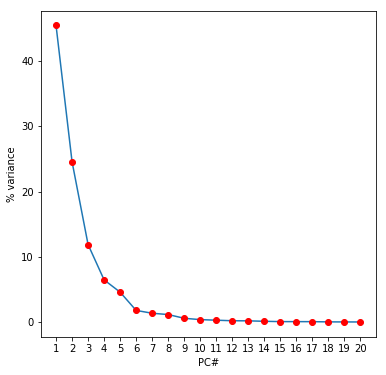

In [34]:
f, ax = plt.subplots(figsize=(6,6))
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100)
ax.plot(range(1,21), skpca.explained_variance_ratio_[0:20]*100,'ro')
ax.set_xticks(range(1,21)); 
ax.set_xlabel('PC#');
ax.set_ylabel("% variance");

In [35]:
ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.99)[0][0]

In [36]:
ipc

12

In [37]:
PCs = skpca.transform(X)

In [38]:
PCs = PCs[:,:ipc]

In [39]:
EOFs = skpca.components_

In [40]:
EOFs = EOFs[:ipc,:]

In [41]:
EOFs.shape

(12, 143)

In [42]:
EOFs_r = EOFs.reshape((ipc, len(lat), len(lon)))

In [43]:
from sklearn.preprocessing import StandardScaler

In [44]:
scaler_PCs = StandardScaler()

In [45]:
scaler_PCs.fit(PCs)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [46]:
PCs_std = scaler_PCs.transform(PCs)

In [47]:
PCdf = pd.DataFrame(PCs_std, index = dset['time'], \
                    columns = ["PC%s" % (x) for x in range(1, PCs_std.shape[1] +1)])

In [48]:
PCdf.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
time,,,,,,,,,,,,
1979-01-01,1.454747,-0.004914,-0.681583,1.177158,-0.981580,-0.950569,-0.100291,-0.823627,0.421368,-0.493433,0.106403,0.107588
1979-01-02,1.068404,-0.557630,0.128019,1.251684,-0.621634,-0.557769,0.764169,0.013579,-0.558789,0.011636,-0.155348,-0.183147
1979-01-03,0.741006,-0.201646,-0.931512,0.800119,0.792590,-0.185484,0.960261,0.425951,-1.038543,-0.326917,0.185424,0.247030
1979-01-04,0.237210,0.284980,-1.475062,0.307317,0.169787,-0.196250,0.731868,-0.629962,0.254374,-0.308137,-0.503634,0.839901
1979-01-05,0.009531,-0.161915,-0.980255,0.887172,-1.182188,-0.627278,0.010283,0.025749,0.211898,0.006511,0.250434,0.086898


In [49]:
PCdf.tail()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
time,,,,,,,,,,,,
2014-12-27,-0.882013,0.050516,0.950078,0.899273,-0.458214,0.511476,0.879151,-0.009012,-1.445596,-0.596346,0.416528,-0.065741
2014-12-28,-1.288674,0.480216,0.459599,0.436350,0.419083,-0.285780,0.285227,0.182786,-0.602984,-0.739703,-0.331119,1.263288
2014-12-29,-0.862789,0.956345,1.298209,-0.019461,-0.483458,-1.313037,-0.166247,0.300744,0.350617,0.168606,-0.637740,1.120087
2014-12-30,0.484581,0.545943,2.060762,0.525226,-1.754418,-0.784332,0.318204,0.219137,0.200827,-0.206660,-0.039647,0.201676
2014-12-31,0.693166,-0.296285,0.621441,1.102874,-0.685905,0.805190,1.343148,-0.006584,-1.643915,0.063263,0.871702,0.362293


In [50]:
from sklearn.cluster import KMeans

In [51]:
nclusters = 12

In [52]:
kmeans = KMeans(init='k-means++', n_clusters=nclusters, n_init=10, n_jobs=-1)

In [53]:
kmeans.fit(PCdf.values)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=12, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [54]:
kmeans.labels_

array([4, 4, 3, ..., 0, 4, 7], dtype=int32)

In [55]:
np.unique(kmeans.labels_)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32)

In [56]:
labels = pd.DataFrame(kmeans.labels_, index=dset['time'], columns=['cluster'])

In [57]:
labels.head()

,cluster
time,
1979-01-01,4
1979-01-02,4
1979-01-03,3
1979-01-04,1
1979-01-05,10


In [58]:
c = 0

In [59]:
index = labels.query('cluster == {}'.format(c))

In [60]:
nbdays = len(index)

In [61]:
nbdays

976

In [62]:
cluster = dset.sel(time=index.index).mean('time')

In [63]:
cluster

<xarray.Dataset>
Dimensions:  (lat: 13, lon: 11)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 -35.0 -37.5 -40.0 -42.5 ...
  * lon      (lon) float32 160.0 162.5 165.0 167.5 170.0 172.5 175.0 177.5 ...
Data variables:
    hgt      (lat, lon) float64 119.3 120.7 122.5 125.0 128.2 131.7 135.0 ...

In [64]:
clusters = []
nbdays = []
for c in range(nclusters): 
    index = labels.query('cluster == {}'.format(c)) 
    nbdays.append(len(index))
    cluster = dset.sel(time=index.index).mean('time')
    clusters.append(cluster)

In [65]:
clusters = xr.concat(clusters, dim='cluster')

In [66]:
clusters

<xarray.Dataset>
Dimensions:  (cluster: 12, lat: 13, lon: 11)
Coordinates:
  * lat      (lat) float32 -25.0 -27.5 -30.0 -32.5 -35.0 -37.5 -40.0 -42.5 ...
  * lon      (lon) float32 160.0 162.5 165.0 167.5 170.0 172.5 175.0 177.5 ...
Dimensions without coordinates: cluster
Data variables:
    hgt      (cluster, lat, lon) float64 119.3 120.7 122.5 125.0 128.2 131.7 ...

/Users/nicolasf/anaconda/envs/IOOS/lib/python3.5/site-packages/seaborn/apionly.py:6: UserWarning: As seaborn no longer sets a default style on import, the seaborn.apionly module is deprecated. It will be removed in a future version.
  warnings.warn(msg, UserWarning)


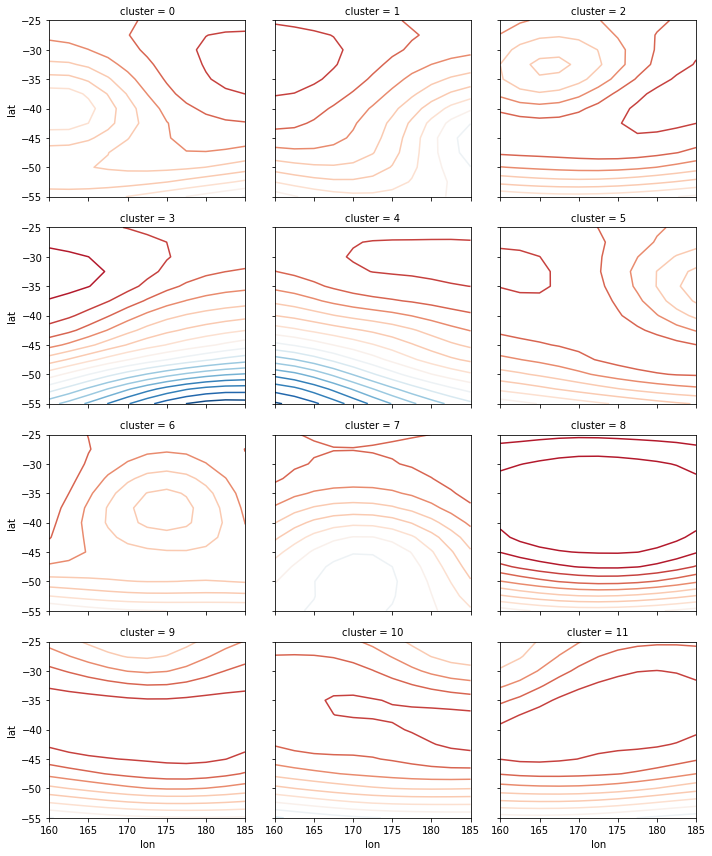

In [67]:
f = clusters['hgt'].plot.contour(x='lon', y='lat', col='cluster', col_wrap=3, levels=np.arange(-150,200,20))

In [167]:
sum(nbdays)

13149

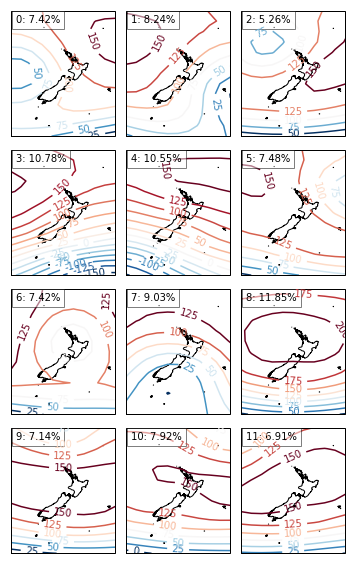

In [170]:
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(6,10), subplot_kw={'projection':proj})
f.subplots_adjust(wspace=0.1, hspace=0.1)
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    clus = clusters.sel(cluster=c)
    make_map(clus['hgt'], lons, lats, step=25, ax=ax)
    ax.text(0.05, 0.9, "{}: {:3.2f}%".format(c, nbdays[c] / sum(nbdays) * 100), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))

+ cluster 5 = R
+ cluster 3 = SW
+ cluster 2 = NE
+ cluster 4 = W 
+ cluster 3 = HNW
+ cluster 0 = HE
+ cluster 7 = T
+ cluster 8 = W

In [171]:
!open ./images/Kidson_Archetypes.png

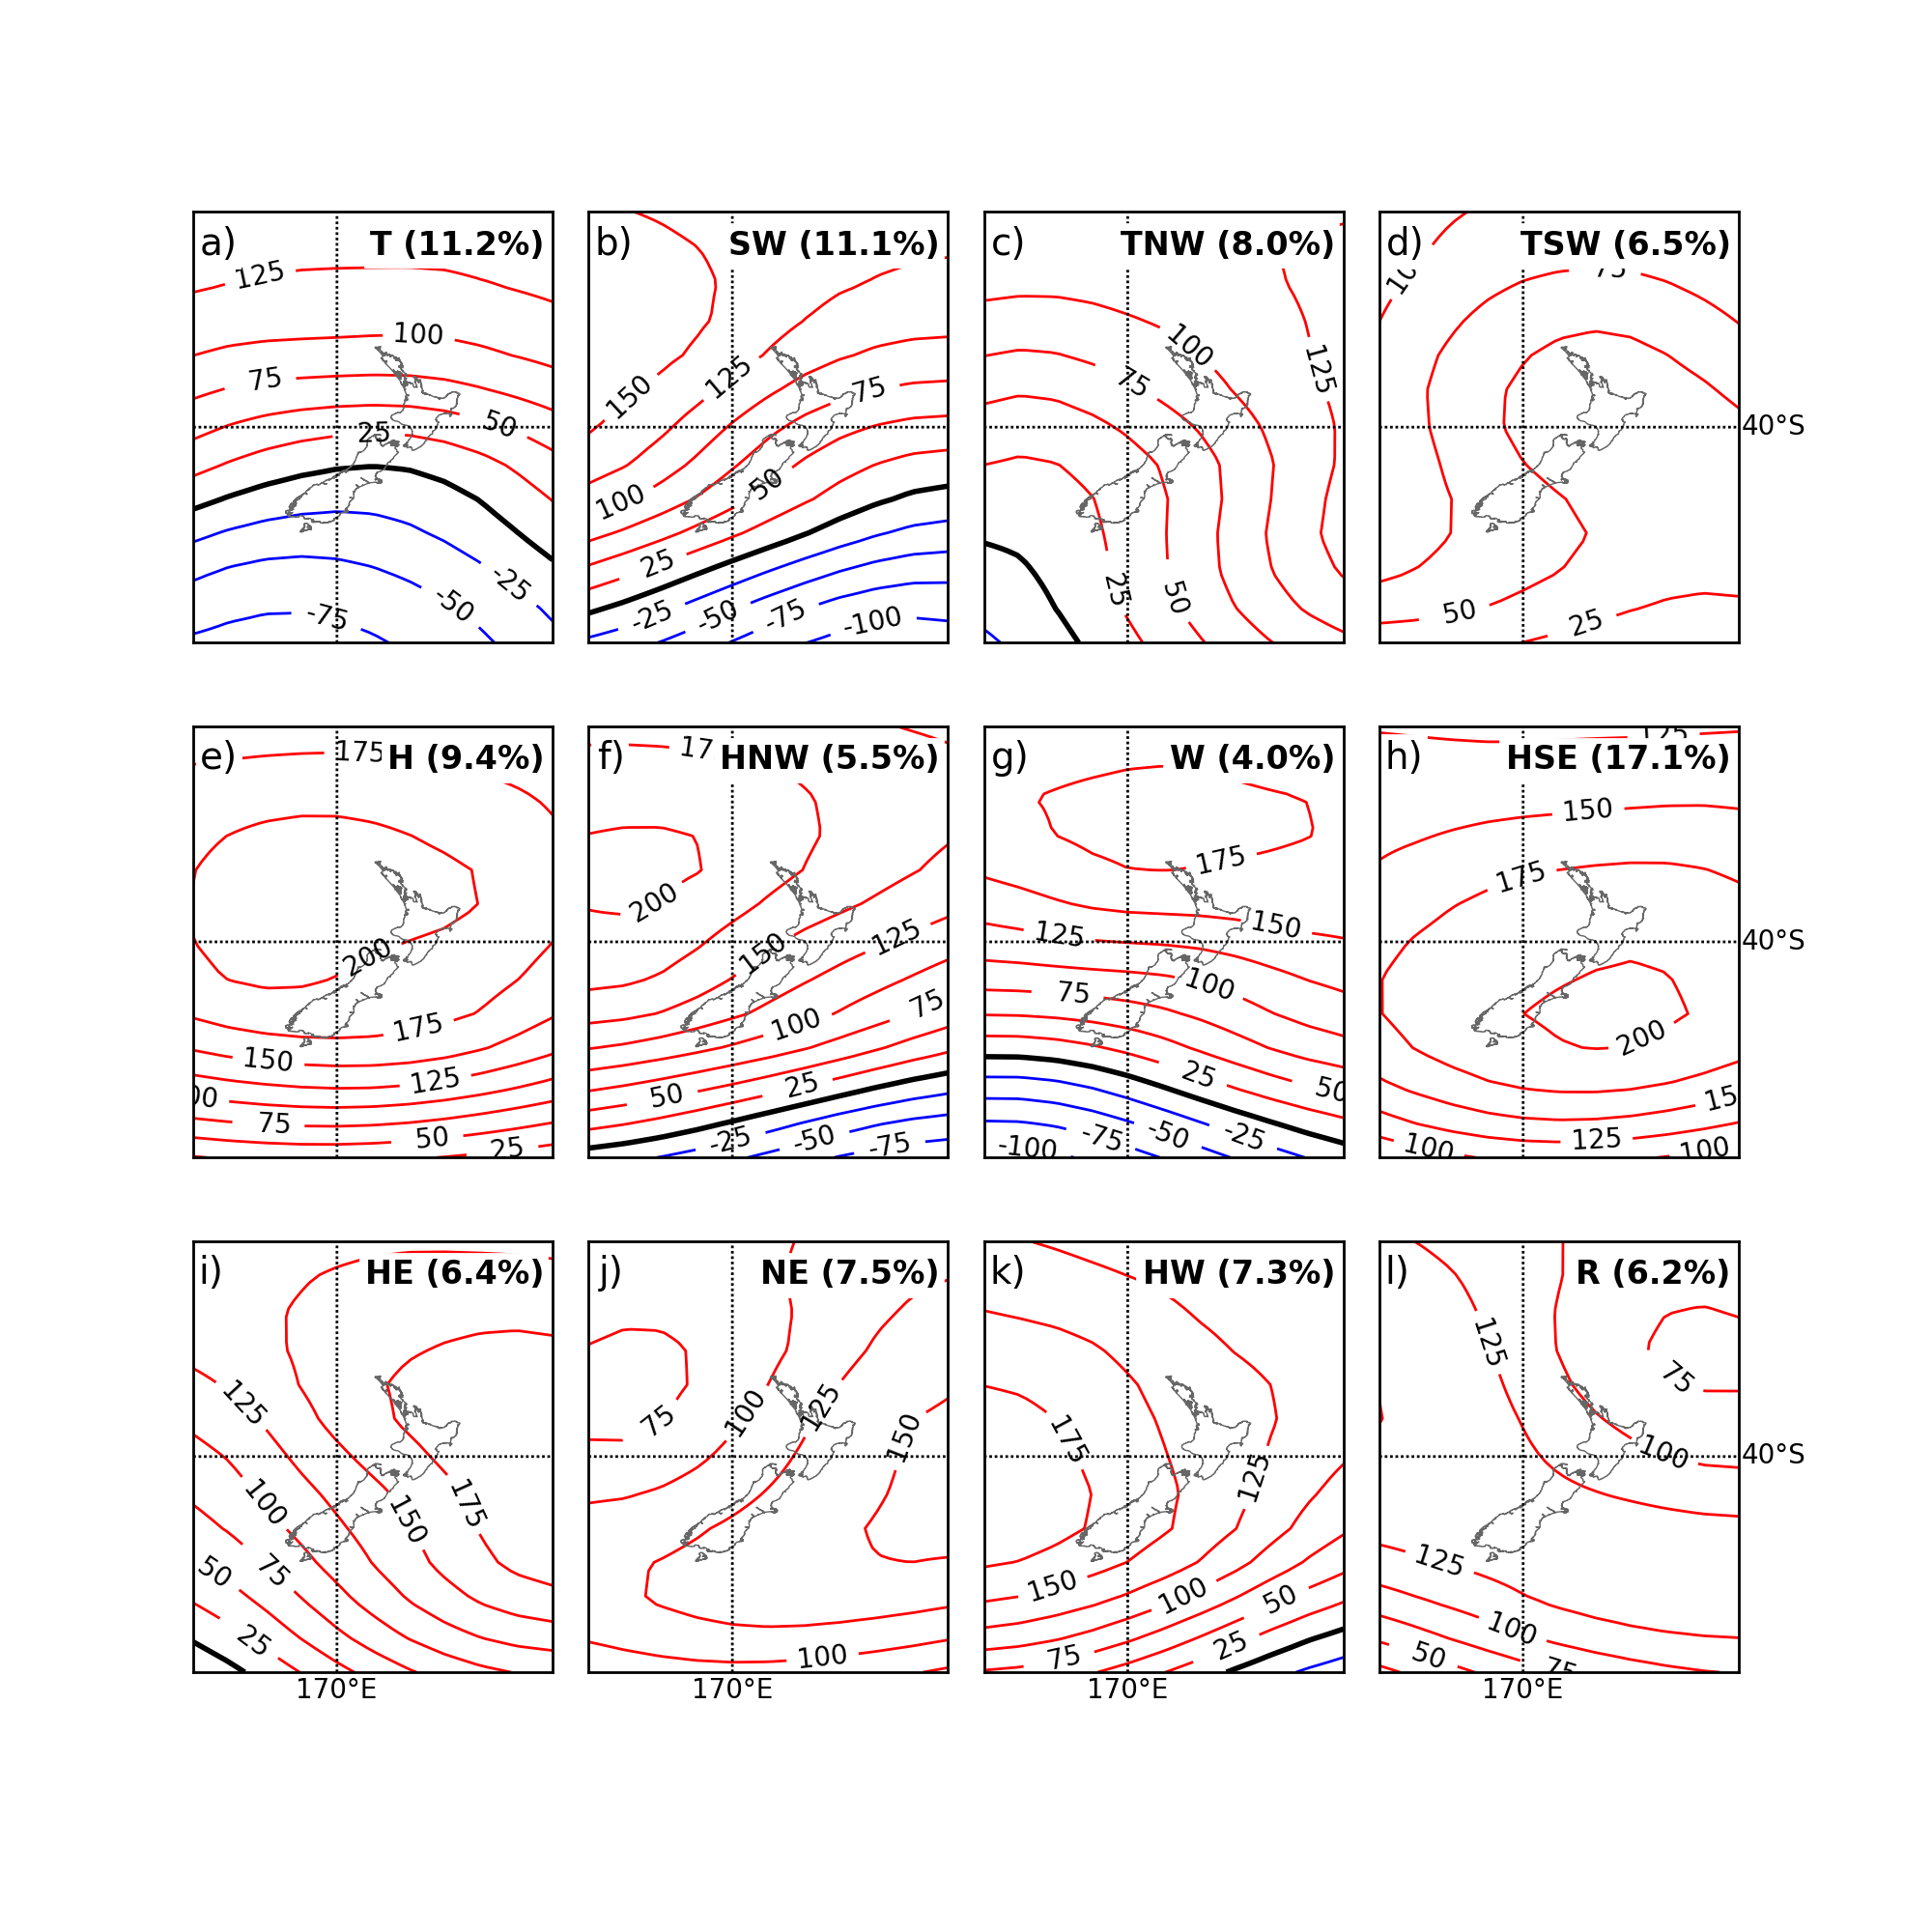

In [163]:
Image('./images/Kidson_Archetypes.png', width=700)

In [104]:
ax = None

In [105]:
if not(ax): 
    print("no")

no


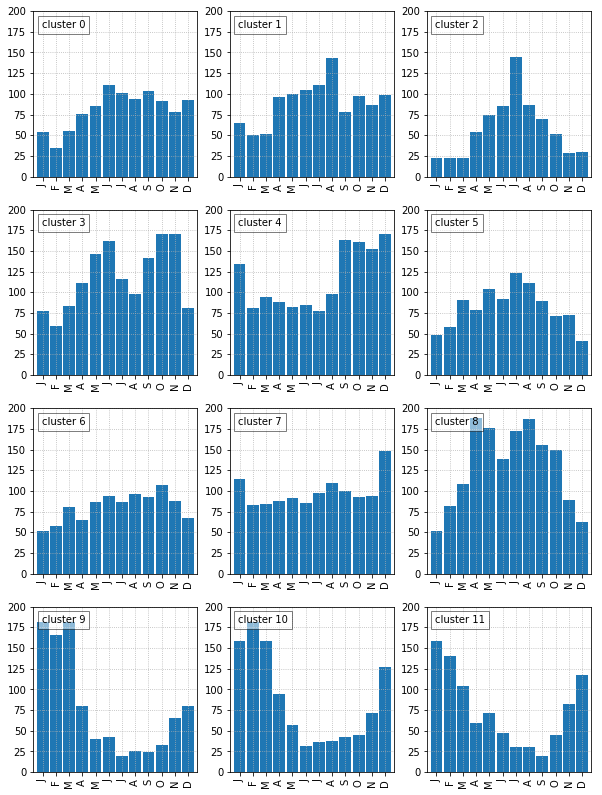

In [97]:
f, axes = plt.subplots(nrows=4, ncols=3, figsize=(10,14))
axes = axes.flatten() 
for c in range(nclusters): 
    ax = axes[c]
    cf = labels.query('cluster == {}'.format(c))
    cf.groupby(cf.index.month).count().plot(kind='bar',width=0.9, ax=ax, legend=None)
    ax.set_ylim(0, 200)
    ax.grid(ls=':')
    ax.text(0.05, 0.9, 'cluster {}'.format(c), transform=ax.transAxes, bbox=dict(facecolor='w', alpha=0.5))
    ax.set_xticklabels(list('JFMAMJJASOND'))
    ax.set_xlabel('')